# 🧾 Jamboree Education - Linear Regression case study
Jamboree has helped thousands of students like you make it to top colleges abroad. Be it GMAT, GRE or SAT, their unique problem-solving methods ensure maximum scores with minimum effort.

### Problem Statement
Jamboree aims to assist Indian students in assessing their probability of securing admission to top foreign universities. The objective of this analysis is to identify the key academic and profile-related factors influencing graduate admissions and to build a predictive model that estimates the Chance of Admit based on these factors.

In [1]:
#Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso

In [2]:
df = pd.read_csv("Jamboree_Admission.csv")
print("First few rows of dataset:")
df.head(10)

First few rows of dataset:


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
5,6,330,115,5,4.5,3.0,9.34,1,0.90
6,7,321,109,3,3.0,4.0,8.20,1,0.75
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45


**Column Profiling:**

* Serial No. (Unique row ID)
* GRE Scores (out of 340)
* TOEFL Scores (out of 120)
* University Rating (out of 5)
* Statement of Purpose and Letter of Recommendation Strength (out of 5)
* Undergraduate GPA (out of 10)
* Research Experience (either 0 or 1)
* Chance of Admit (ranging from 0 to 1)

In [3]:
#Data Exploration
print("Rows and columns in the Dataset:")
df.shape

Rows and columns in the Dataset:


(500, 9)

In [4]:
print("Columns in the dataset:")
df.columns

Columns in the dataset:


Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [5]:
df.nunique(axis=0)

Serial No.           500
GRE Score             49
TOEFL Score           29
University Rating      5
SOP                    9
LOR                    9
CGPA                 184
Research               2
Chance of Admit       61
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


In [7]:
df1=df.copy()

In [8]:
# Removing unqiue row identifiers as we don not want our model to build any understanding based on row numbers
df1.drop(columns=['Serial No.'], inplace=True)

In [9]:
df1.rename(columns={'LOR ':'LOR', 'Chance of Admit ':'Chance of Admit'}, inplace=True)

In [10]:
# Columns with limited unique values converted to Category Data Type
df1[['University Rating', 'SOP', 'LOR','Research']] = df1[['University Rating', 'SOP', 'LOR','Research']].astype('category')

In [11]:
int_columns=['GRE Score','TOEFL Score']
for i in int_columns:
  df1[i]=df1[i].astype('int16')

In [12]:
float_columns=['CGPA','Chance of Admit']
for i in float_columns:
  df1[i]=df1[i].astype('float16')

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   GRE Score          500 non-null    int16   
 1   TOEFL Score        500 non-null    int16   
 2   University Rating  500 non-null    category
 3   SOP                500 non-null    category
 4   LOR                500 non-null    category
 5   CGPA               500 non-null    float16 
 6   Research           500 non-null    category
 7   Chance of Admit    500 non-null    float16 
dtypes: category(4), float16(2), int16(2)
memory usage: 7.0 KB


Post Converting the required columns to category data type and reducing the size of integer and float data types the memory usage is reduced from 35.3 kb to 7 kb which is **80.2%** improvement

In [14]:
df1.describe(include='all')

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.0,500.0,500.0,500.000000,500.0,500.000000
unique,NaN,NaN,5.0,9.0,9.0,NaN,2.0,NaN
top,NaN,NaN,3.0,4.0,3.0,NaN,1.0,NaN
freq,NaN,NaN,162.0,89.0,99.0,NaN,280.0,NaN
mean,316.472000,107.192000,NaN,NaN,NaN,8.578125,NaN,0.721680
std,11.295148,6.081868,NaN,NaN,NaN,0.604492,NaN,0.141113
min,290.000000,92.000000,NaN,NaN,NaN,6.800781,NaN,0.340088
25%,308.000000,103.000000,NaN,NaN,NaN,8.128906,NaN,0.629883
50%,317.000000,107.000000,NaN,NaN,NaN,8.562500,NaN,0.720215
75%,325.000000,112.000000,NaN,NaN,NaN,9.039062,NaN,0.819824


**Check Duplicate Records**

In [15]:
df1.duplicated().sum()

np.int64(0)

**Check Outliers**

In [16]:
numeric_cols = ['GRE Score','TOEFL Score', 'CGPA', 'Chance of Admit']

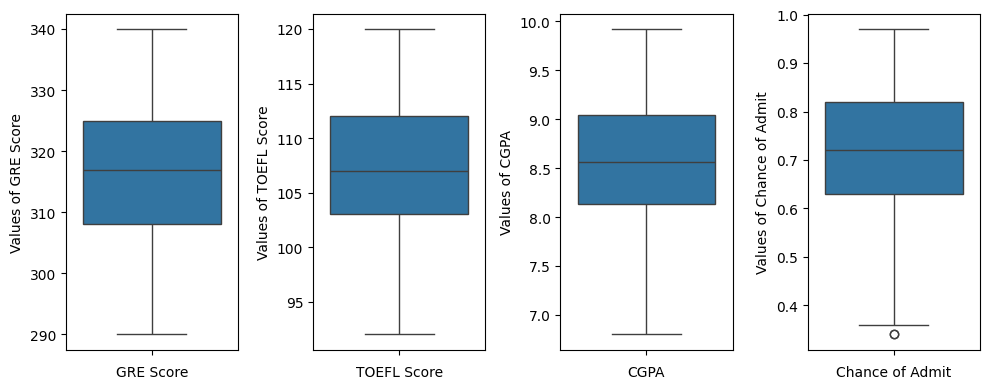

In [17]:
# Check for outliers in numerical columns
plt.figure(figsize=(10,4))
i=1
for col in numeric_cols:
  ax = plt.subplot(1,4,i)
  sns.boxplot(df1[col])
  #plt.title(col)
  plt.xlabel(col)
  plt.ylabel(f'Values of {col}')
  i+=1
plt.tight_layout()
plt.show()

It is clearly observed that there are hardly any Outliers in this data

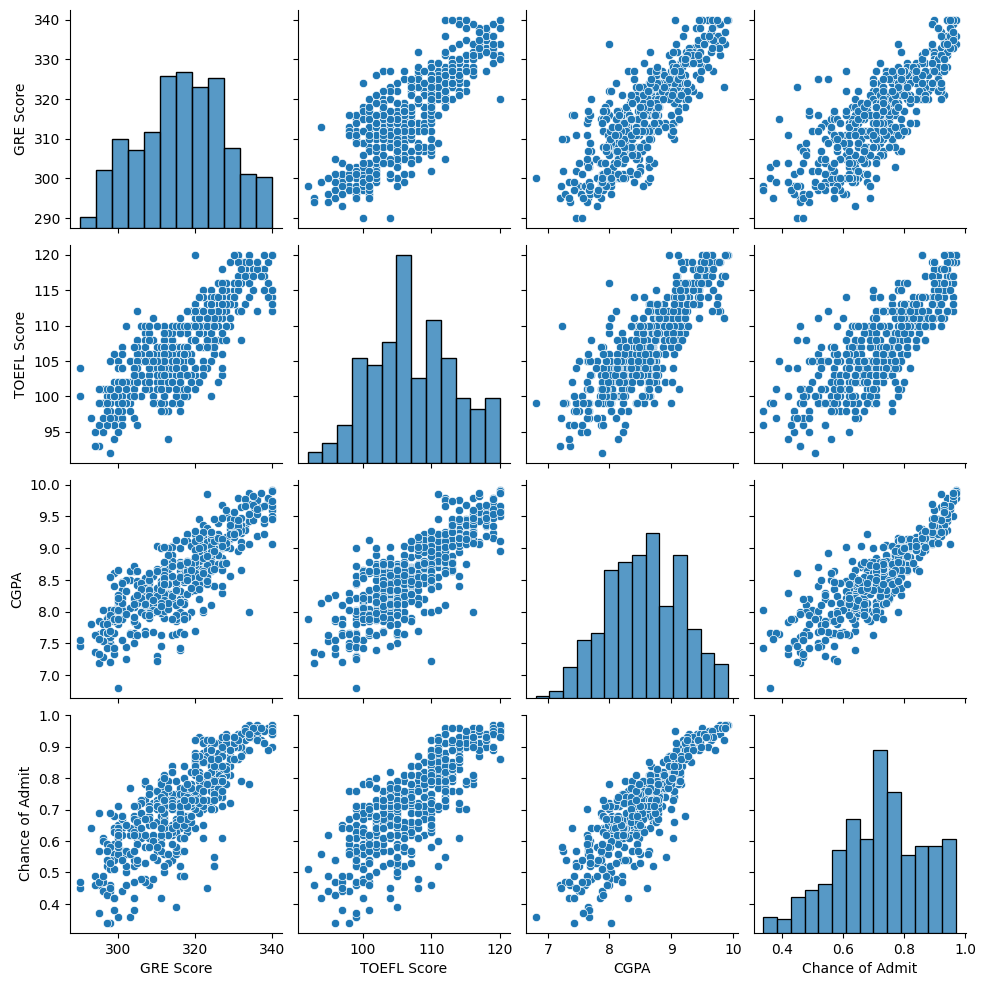

In [18]:
#Correlation Among Independent Variables
sns.pairplot(df1)
plt.show()

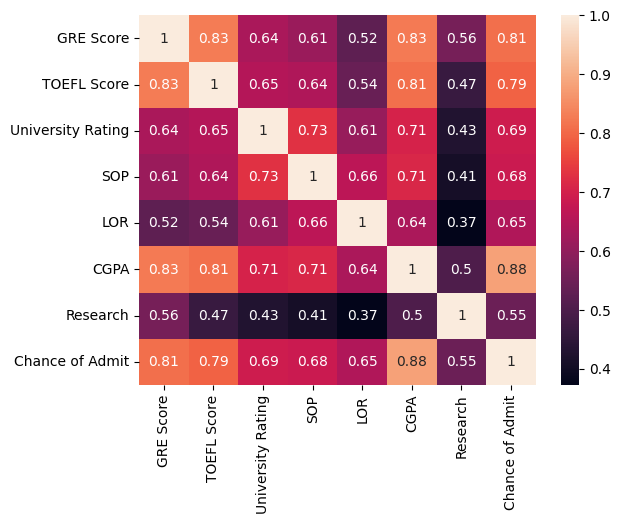

In [19]:
sns.heatmap(df1.corr(),annot=True)
plt.show()

Observations:

1. CGPA, TOEFL Score and GRE Score show strong positive correlation to Chance of Admit
2. University Rating show positive correlation to Chance of Admit, CGPA and all other factors except Research
3. Chance of Admit show strong positive correlation to CGPA, GRE Score, TOEFL Score
4. Research shows weak positive correlation to all other factors

#Distribution of Variables

- Univariate Analysis
- Bivariate Analysis

Distribution of Continuous Variables

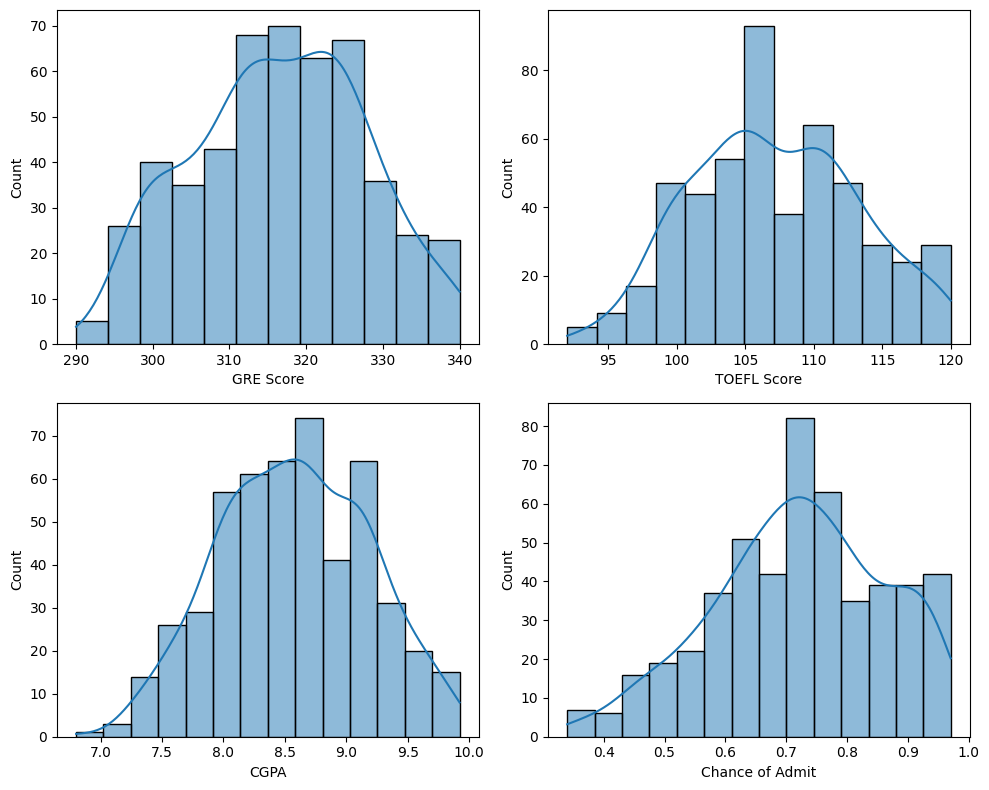

In [20]:
plt.figure(figsize=(10,8))
i=1
for col in numeric_cols:
  ax=plt.subplot(2,2,i)
  sns.histplot(data=df1[col], kde=True)
  #plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel('Count')
  i += 1

plt.tight_layout()
plt.show()

INSIGHTS:

1. GRE Scores are in the range 290 to 340 with most of the students in the scoring in the range 310-320
2. TOEFL Scores are in the range 90 to 120 with maximum students scoring in range 105-110
3. CGPA is in the range 7-10 with maximum between 8.5 and 9
4. Chance of Admit is maximum with 70%-75%

Distribution of Categorical Variables

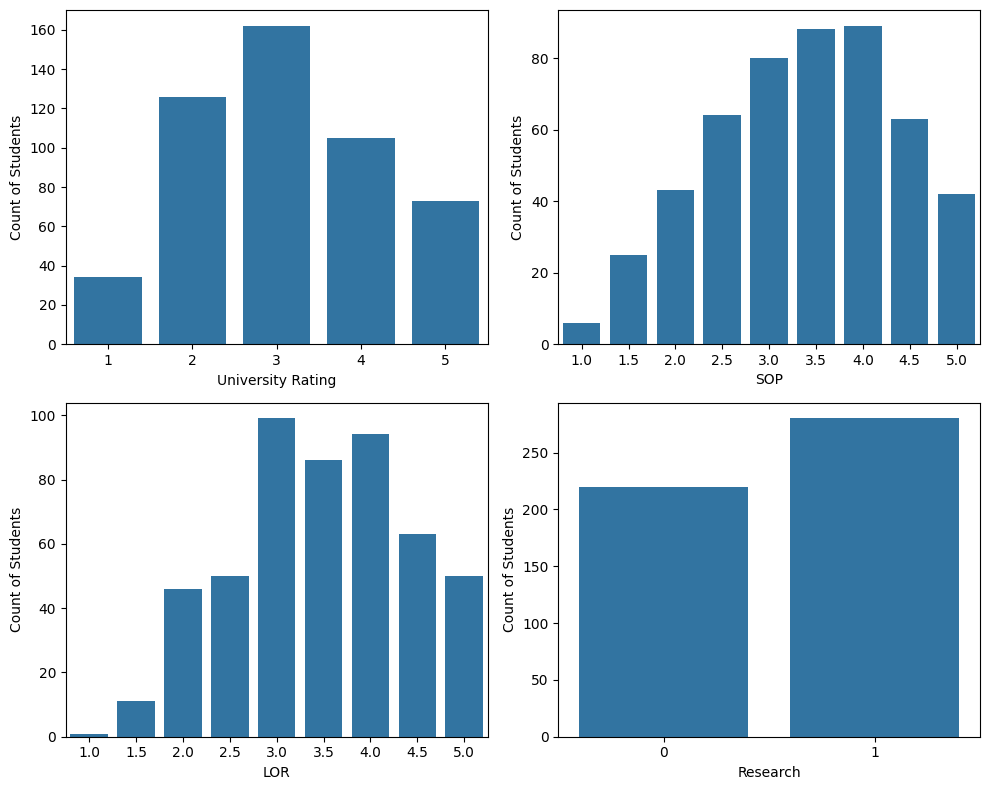

In [21]:
cat_cols=['University Rating', 'SOP', 'LOR','Research']
plt.figure(figsize=(10,8))
i=1

for col in cat_cols:
  ax = plt.subplot(2,2,i)
  sns.countplot(x=df1[col])
  #plt.title(f'Distribution of {col}', fontsize=10)
  plt.xlabel(col)
  plt.ylabel('Count of Students')
  i+=1

plt.tight_layout()
plt.show();

INSIGHTS:
1. Most of the students belong to University with rating 3 followed by 2 and 4
2. Maximum students have got Statement of Purpose with strength 4 followed by 3.5 and 3
3. Letter of Recommendation with strength 3 have got maximum number of students
4. Most of the students have got research done


Bivariate Analysis

To understand relationship between each of the categorical variables and Chance of Admit

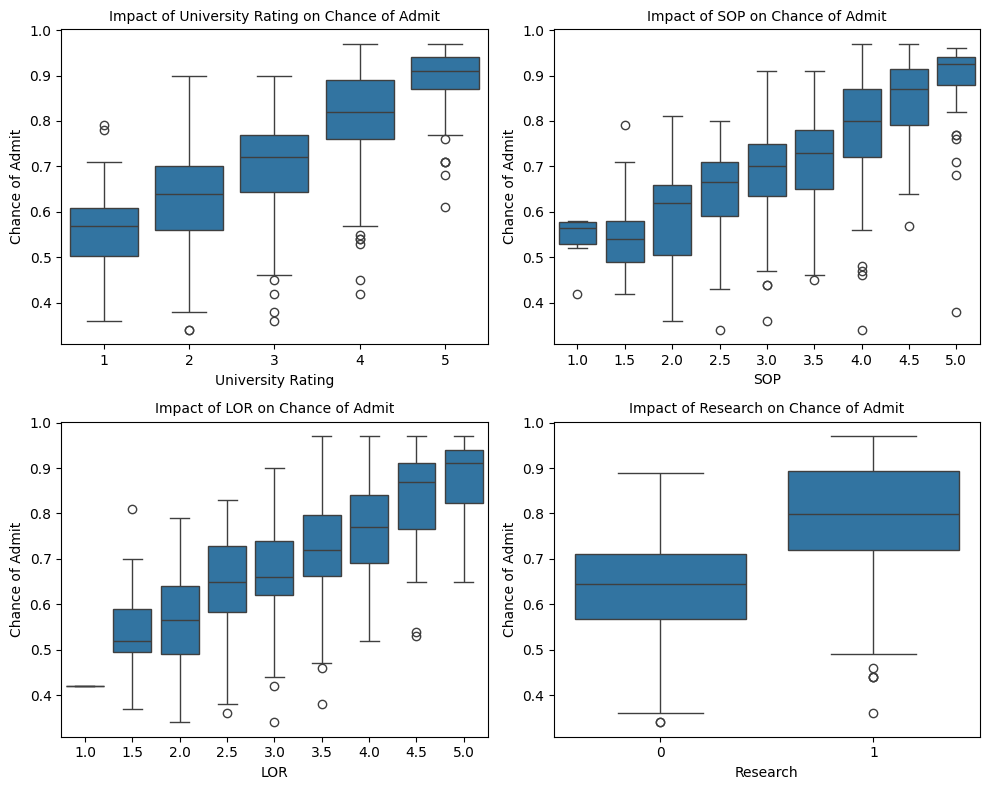

In [22]:
plt.figure(figsize=(10,8))
i=1
for col in cat_cols:
  ax = plt.subplot(2,2,i)
  sns.boxplot(data = df1, x=col, y='Chance of Admit')
  plt.title(f"Impact of {col} on Chance of Admit", fontsize=10)
  plt.xlabel(col)
  plt.ylabel('Chance of Admit')
  i+=1

plt.tight_layout()
plt.show()

INSIGHTS:

1. Chance of Admit is highest for University with rating 5 followed by 4,3,2,1
2. COA is maximum for SOP strength of 5 anf henceforth decreasing uptil 1
3. LOR with strength 5 has the maximum chance of admit
4. Students who have done research have higher chance of admit

# Preparation for Modeling

- Perform Train-Test Split
- Perform Data Normalization / Standardization

**Train Test Split**

In [23]:
df2=df.copy()

In [24]:
df2.drop(columns=['Serial No.'], inplace=True)

In [25]:
df2.rename(columns={'LOR ':'LOR', 'Chance of Admit ':'Chance of Admit'}, inplace=True)

In [26]:
# Separate predictor and target variables
x = df2.drop(columns=['Chance of Admit'])
y = df2[['Chance of Admit']]

In [27]:
x.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0


In [28]:
y.head()

,Chance of Admit
0,0.92
1,0.76
2,0.72
3,0.80
4,0.65


In [29]:
# Split the data into training and test data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                     random_state=42)

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of x_train: (400, 7)
Shape of x_test: (100, 7)
Shape of y_train: (400, 1)
Shape of y_test: (100, 1)


In [30]:
x_train

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
249,321,111,3,3.5,4.0,8.83,1
433,316,111,4,4.0,5.0,8.54,0
19,303,102,3,3.5,3.0,8.50,0
322,314,107,2,2.5,4.0,8.27,0
332,308,106,3,3.5,2.5,8.21,1
...,...,...,...,...,...,...,...
106,329,111,4,4.5,4.5,9.18,1
270,306,105,2,2.5,3.0,8.22,1
348,302,99,1,2.0,2.0,7.25,0
435,309,105,2,2.5,4.0,7.68,0


**Standard Scaling**

In [31]:
# Create a StandardScaler object
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [32]:
x_train_scaled

array([[ 0.38998634,  0.6024183 , -0.09829757, ...,  0.56498381,
         0.4150183 ,  0.89543386],
       [-0.06640493,  0.6024183 ,  0.7754586 , ...,  1.65149114,
        -0.06785154, -1.11677706],
       [-1.25302222, -0.87691722, -0.09829757, ..., -0.52152352,
        -0.13445427, -1.11677706],
       ...,
       [-1.34430047, -1.37002906, -1.8458099 , ..., -1.60803084,
        -2.2157898 , -1.11677706],
       [-0.7053527 , -0.38380538, -0.97205374, ...,  0.56498381,
        -1.49981038, -1.11677706],
       [-0.24896144, -0.21943477, -0.97205374, ...,  0.02173015,
        -0.55072138, -1.11677706]], shape=(400, 7))

In [33]:
# Linear Regression Model
X_sm = sm.add_constant(x_train_scaled)
sm_model = sm.OLS(y_train, X_sm).fit()

print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:        Chance of Admit   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     257.0
Date:                Thu, 29 Jan 2026   Prob (F-statistic):          3.41e-142
Time:                        12:38:17   Log-Likelihood:                 561.91
No. Observations:                 400   AIC:                            -1108.
Df Residuals:                     392   BIC:                            -1076.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7242      0.003    241.441      0.0

In [34]:
column_names = list(x_train.columns)

# Get the model parameters (coefficients) including the constant term
model_parameters = list(sm_model.params[1:])
modelparam2= list(sm_model.pvalues[1:])

# Create a DataFrame to display the model coefficients with column names
coefficients = pd.DataFrame({'Variable': column_names, 'Coefficient': model_parameters, 'P-Value': modelparam2})
print(coefficients)

            Variable  Coefficient       P-Value
0          GRE Score     0.026671  3.357625e-05
1        TOEFL Score     0.018226  1.619658e-03
2  University Rating     0.002940  5.414408e-01
3                SOP     0.001788  7.211636e-01
4                LOR     0.015866  1.947965e-04
5               CGPA     0.067581  1.086636e-22
6           Research     0.011940  1.337508e-03


It is clear from above that 'University Rating' and 'SOP' have p-value>0.05 , signifying that these two features have no statistically significant effect on the dependent variable

Therefore, we shall remove these two features and re-train the model

In [35]:
df3=df.copy()

In [36]:
df3.rename(columns={'LOR ':'LOR', 'Chance of Admit ':'Chance of Admit'}, inplace=True)

In [37]:
# Separate predictor and target variables
x = df3.drop(columns=['Chance of Admit','University Rating','SOP','Serial No.'])
y = df3[['Chance of Admit']]

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)

In [39]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training & test data
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [40]:
X_sm = sm.add_constant(x_train_scaled)

sm_model = sm.OLS(y_train, X_sm).fit()

print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:        Chance of Admit   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     360.8
Date:                Thu, 29 Jan 2026   Prob (F-statistic):          1.36e-144
Time:                        12:38:17   Log-Likelihood:                 561.54
No. Observations:                 400   AIC:                            -1111.
Df Residuals:                     394   BIC:                            -1087.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7242      0.003    241.830      0.0

In [41]:
column_names = list(x_train.columns)

# Get the model parameters (coefficients) including the constant term
model_parameters = list(sm_model.params[1:])
modelparam2= list(sm_model.pvalues[1:])

# Create a DataFrame to display the model coefficients with column names
coefficients = pd.DataFrame({'Variable': column_names, 'Coefficient': model_parameters, 'P-Value': modelparam2})
print(coefficients)

      Variable  Coefficient       P-Value
0    GRE Score     0.026879  2.731841e-05
1  TOEFL Score     0.019106  7.667483e-04
2          LOR     0.017207  1.045150e-05
3         CGPA     0.069066  2.882599e-25
4     Research     0.012226  9.557871e-04


Observations:

1. We will now move ahead with 5 features as mentioned since their p-values are less then 0.05 and have statistically significant effect on the dependent variable
2. R-square and Adj. R-square are almost same signifying that 82% of the variance in dependent variable is explained by independent variables
3. Condition Number is further reduced to 4.76 which is well below 30 to inidicate that there is no multicollinearity
4. Low Prob(F-statistic) value indicate that the model is statistically significant
5. CGPA carry maximum weightage followed by GRE Score, TOEFL Score, LOR and Research signifying strength of relationship with the dependent variable  

# Test Assumptions of Linear Regression

**Multicollinearity Check**

In [42]:
vif = pd.DataFrame()
X_t = pd.DataFrame(x_train_scaled, columns=x_train.columns)
vif['Features'] = X_t.columns
vif['VIF'] = [variance_inflation_factor(X_t.values, i) for i in range(X_t.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,GRE Score,4.47
3,CGPA,4.28
1,TOEFL Score,3.54
2,LOR,1.66
4,Research,1.50


VIF Value of all Features are well below 5 which means this model is good to go ahead

**Mean of Residuals**

In [43]:
# Add constant to the scaled test data
X_test_sm = sm.add_constant(x_test_scaled)

# Predict the target variable for the test dataset
y_pred_test = sm_model.predict(X_test_sm)

In [44]:
y_test_values = y_test.values.flatten()  # Convert to 1D array

# calculating the mean of residuals for the test dataset
residuals_test = y_test_values - y_pred_test
mean_residuals_test = np.mean(residuals_test)

# Print the mean of residuals for the test dataset
print("Mean of Residuals (Test Data):", mean_residuals_test)

Mean of Residuals (Test Data): -0.005305947942349183


Mean of Residuals on the Test Data is found to be -0.0053 which is close to 0 indicating a tendency for underestimation, the small magnitude indicates that the model's predictions are generally close to the actual values.

**Linearity between Dependent and Independent Variables**

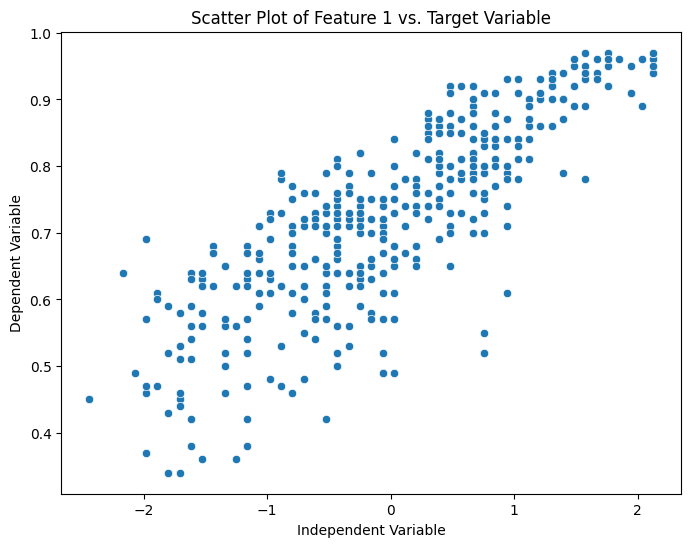

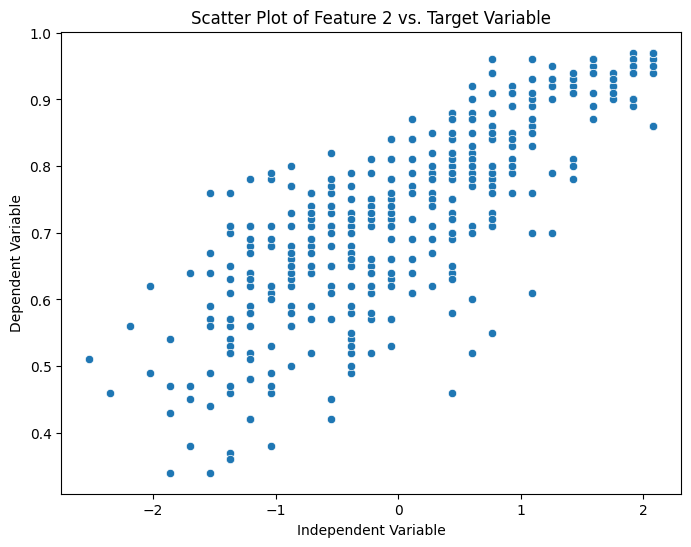

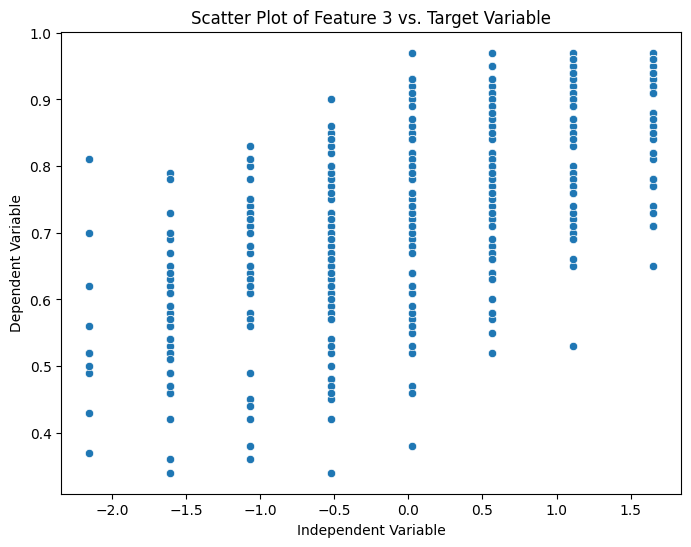

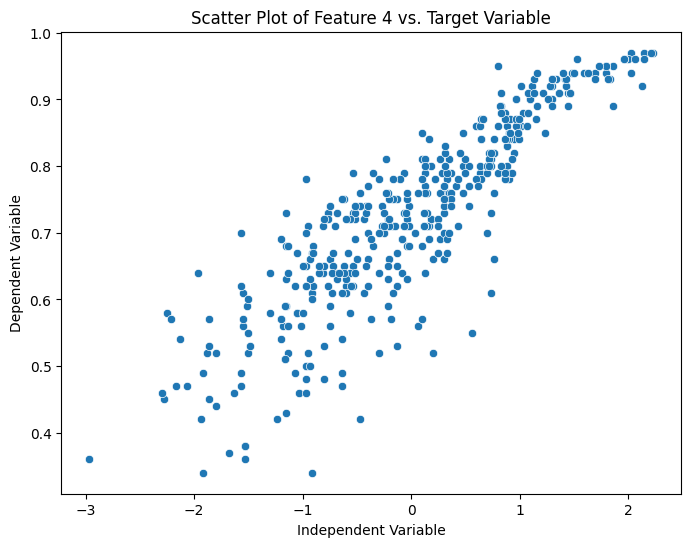

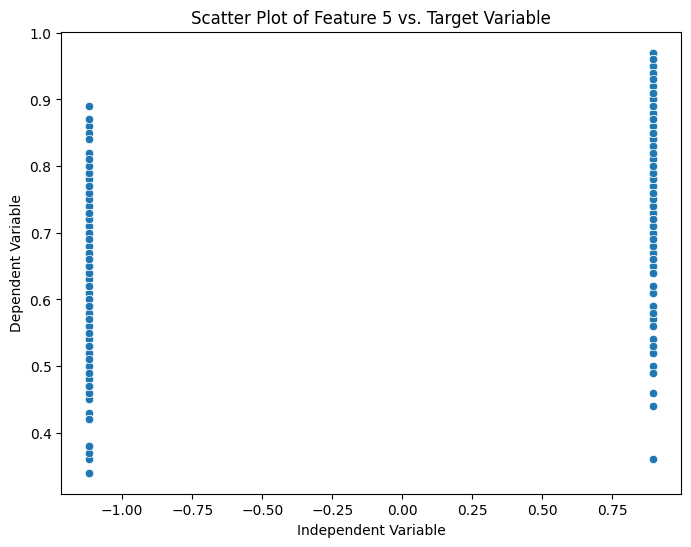

In [45]:
y_train_1d = np.array(y_train).reshape(-1)

# Scatter plots for each independent variable against the dependent variable
for i in range(x_train_scaled.shape[1]):  # Assuming x_train_scaled is a NumPy array
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x_train_scaled[:, i].reshape(-1), y=y_train_1d)  # Reshape to 1D array
    plt.xlabel('Independent Variable')
    plt.ylabel('Dependent Variable')
    plt.title(f'Scatter Plot of Feature {i+1} vs. Target Variable')
    plt.show()

LOR And Research are Categorical type of data. CGPA / GRE Score / TOEFL Score almost show linear relationship which can be observed with correlation matrix / pairplot and the p_value of the test statistic in the OLS Regression Summary

**Test for Homoscedasticity**

In [46]:
Y_hat = sm_model.predict(X_sm)

In [47]:
if isinstance(y_train, pd.Series):
    print("y_train is a Pandas Series")
elif isinstance(y_train, pd.DataFrame):
    print("y_train is a Pandas DataFrame")
else:
    print("y_train is neither a Pandas Series nor a Pandas DataFrame")

y_train is a Pandas DataFrame


In [48]:
print(y_train.columns)

Index(['Chance of Admit'], dtype='object')


In [49]:
# Select the appropriate column from y_train (assuming it's named 'target_column')
y_train_column = y_train['Chance of Admit']

# Calculate errors as the difference between Y_hat and y_train_column
errors = Y_hat - y_train_column.values

Text(0.5, 1.0, 'Predicted values vs Residuals')

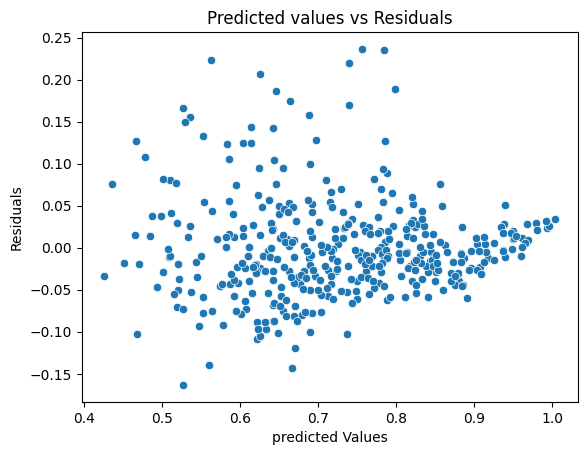

In [50]:
sns.scatterplot(x=Y_hat,y=errors)
plt.xlabel("predicted Values")
plt.ylabel("Residuals")
plt.title("Predicted values vs Residuals")

Using **Goldfeld Quandt Test** to check homoskedacity

In [51]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

In [52]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(y_train, X_sm)
lzip(name, test)

[('F statistic', np.float64(0.9592288620962851)),
 ('p-value', np.float64(0.6139024845884404))]

From the goldfeld-quandt test:

F Statistic comes out to be 0.959 => Implying minimal difference in variance between groups.

p-value of 0.613 indicates that this difference is statistically significant at conventional levels of significance (e.g., 0.05).

Therefore, we accept the null hypothesis of homoscedasticity, and conclude that there is no strong evidence of heteroscedasticity in the data.

**Normality of Residuals**

Text(0.5, 1.0, 'Histogram of residuals')

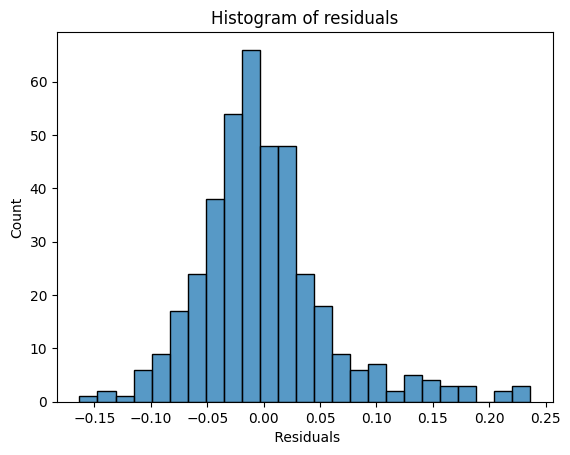

In [53]:
sns.histplot(errors)
plt.xlabel(" Residuals")
plt.title("Histogram of residuals")

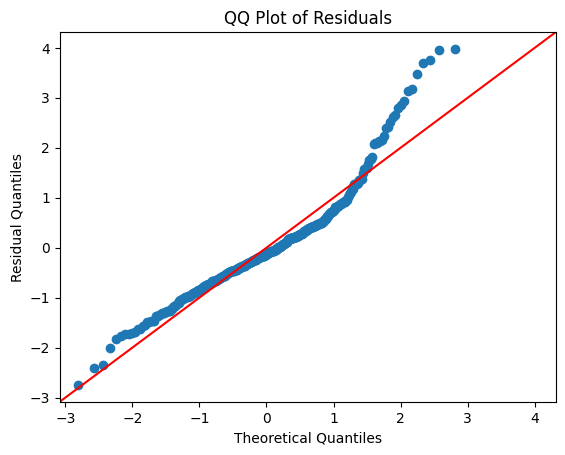

In [54]:
sm.qqplot(errors,line='45',fit=True)
plt.title('QQ Plot of Residuals')
plt.ylabel('Residual Quantiles')
plt.show()

**Shapiro wilk Test** of Normality

In [55]:
from scipy import stats
res = stats.shapiro(errors)
res.statistic

np.float64(0.931256678230213)

Closer the value to 1, more is the normality.

In this case, a value of 0.93 denotes a high level of normality for the error distribuiton

Graphical Representation and Statistical proof namely Shapiro Wilk Test, both prove that the Residual errors are following normal distribution.



# Evaluate Model Performance

In [56]:
def adjusted_r2_score(y_true, y_pred, n_features):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_features - 1))
    return adjusted_r2

# MAE (Mean Absolute Error)
train_mae = mean_absolute_error(y_train, Y_hat)
test_mae = mean_absolute_error(y_test, y_pred_test)

# RMSE (Root Mean Square Error)
train_rmse = np.sqrt(mean_squared_error(y_train, Y_hat))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# R-squared value
train_r2 = r2_score(y_train, Y_hat)
test_r2 = r2_score(y_test, y_pred_test)

# Number of features in the model (assuming X_train is your feature matrix)
n_features = x_train_scaled.shape[1]

# Adjusted R-squared value
train_adj_r2 = adjusted_r2_score(y_train, Y_hat, n_features)
test_adj_r2 = adjusted_r2_score(y_test, y_pred_test, n_features)

print("Training set:")
print("MAE:", train_mae)
print("RMSE:", train_rmse)
print("R-squared:", train_r2)
print("Adjusted R-squared:", train_adj_r2)

print("\nTesting set:")
print("MAE:", test_mae)
print("RMSE:", test_rmse)
print("R-squared:", test_r2)
print("Adjusted R-squared:", test_adj_r2)

Training set:
MAE: 0.04269126483606392
RMSE: 0.05944028044169098
R-squared: 0.8207326947514393
Adjusted R-squared: 0.8184577289487925

Testing set:
MAE: 0.0429234557826578
RMSE: 0.06142491974041884
R-squared: 0.8155002070847484
Adjusted R-squared: 0.8056863883126605


* The model performs well on both the training and testing sets, as indicated by
small MAE and RMSE values and high R-squared and adjusted R-squared values.

* The model appears to generalize well to unseen data (testing set), as the performance metrics on the testing set are comparable to those on the training set.

# Ridge and Lasso Regression

In [57]:
lasso_model = Lasso()
ridge_model = Ridge()

In [58]:
lasso_model.fit(x_train_scaled, y_train)
ridge_model.fit(x_train_scaled, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [59]:
lasso_predictions = lasso_model.predict(x_test_scaled)
ridge_predictions = ridge_model.predict(x_test_scaled)

In [60]:
print('test MSE for L1:', mean_squared_error(y_test, lasso_predictions))
print('test MSE for L2:', mean_squared_error(y_test, ridge_predictions))

print("R^2 for lasso:",lasso_model.score(x_test_scaled,y_test))
print('R^2 for ridge:',ridge_model.score(x_test_scaled,y_test))

test MSE for L1: 0.020598230624999995
test MSE for L2: 0.0037770066475508414
R^2 for lasso: -0.00724844132029312
R^2 for ridge: 0.8153052984082718


In [61]:
lasso_train_predictions = lasso_model.predict(x_train_scaled)
ridge_train_predictions = ridge_model.predict(x_train_scaled)

In [62]:
print('train MSE for L1:', mean_squared_error(y_train, lasso_train_predictions))
print('train MSE for L2:', mean_squared_error(y_train, ridge_train_predictions))

print("R^2 for lasso:",lasso_model.score(x_train_scaled,y_train))
print('R^2 for ridge:',ridge_model.score(x_train_scaled,y_train))

train MSE for L1: 0.019708819375
train MSE for L2: 0.0035332093876228863
R^2 for lasso: 0.0
R^2 for ridge: 0.8207295261884308


Observations:

-  A lower MSE indicates better model performance in terms of fitting the training data. Therefore, the L2 regularization (Ridge) model has a lower train MSE compared to the L1 regularization (Lasso) model.

- A higher R-squared value indicates that a larger proportion of the variance in the dependent variable is explained by the independent variables. Therefore, the Ridge regularization model explains more variance in the target variable compared to the Lasso regularization model.

- The L2 regularization (Ridge) model outperforms the L1 regularization (Lasso) model in terms of both train MSE and R-squared value.


# Identifying Better Model

- Linear Regression
- Lasso Regression
- Ridge Regression

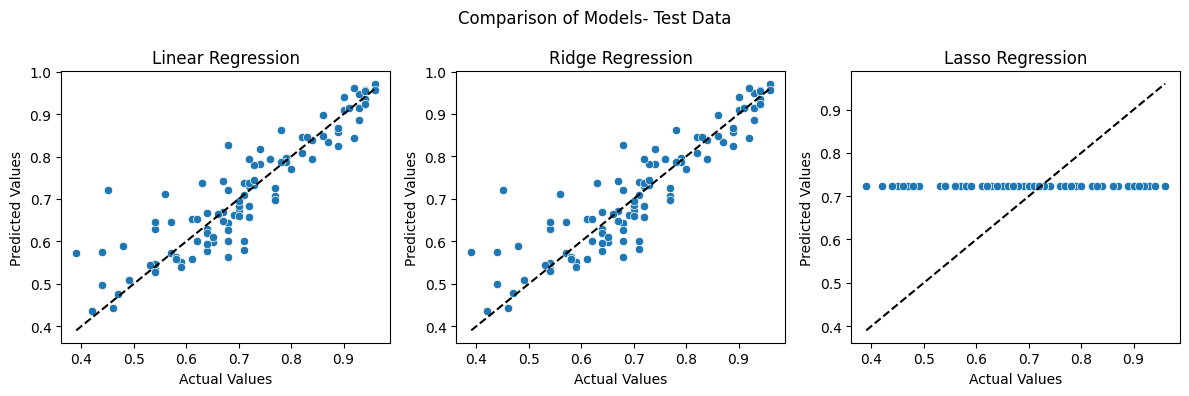

In [63]:
actual_values = y_test.values.reshape((-1,))
predicted_values = [y_pred_test.reshape((-1,)), ridge_predictions.reshape((-1,)), lasso_predictions.reshape((-1,))]
model = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

plt.figure(figsize=(12,4))
i=1
for preds in predicted_values:
  ax = plt.subplot(1,3,i)
  sns.scatterplot(x=actual_values, y=preds)
  plt.plot([min(actual_values),max(actual_values)], [min(actual_values),max(actual_values)], 'k--')
  plt.suptitle('Comparison of Models- Test Data')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title(model[i-1])
  i+=1

plt.tight_layout()
plt.show();

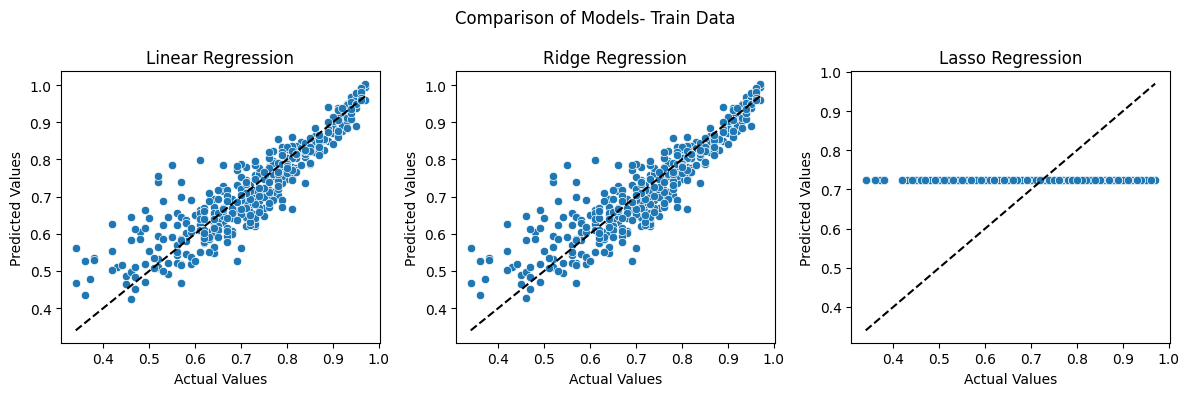

In [64]:
actual_values = y_train.values.reshape((-1,))
predicted_values = [Y_hat.reshape((-1,)), ridge_train_predictions.reshape((-1,)), lasso_train_predictions.reshape((-1,))]
model = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

plt.figure(figsize=(12,4))
i=1
for preds in predicted_values:
  ax = plt.subplot(1,3,i)
  sns.scatterplot(x=actual_values, y=preds)
  plt.plot([min(actual_values),max(actual_values)], [min(actual_values),max(actual_values)], 'k--')
  plt.suptitle('Comparison of Models- Train Data')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title(model[i-1])
  i+=1

plt.tight_layout()
plt.show();

We can observe that both Linear Regression and Ridge Regression have similar accuracy while Lasso regression has oversimplified the model.

## Insights

* Overall, the higher MSE and zero R-squared value of the Lasso regularization model suggest that it may have oversimplified the model by aggressively shrinking coefficients and selecting fewer features, ultimately leading to poorer performance in capturing the relationships present in the data.
* This is the reason that the r2 score of Lasso regression is 0. It doesn't capture any variance in the target variable. It has predicted the same value across all instances.
* Both Linear Regression and Ridge Regression models, which are better models, have captured upto 82% of the variance in the target variable (chance of admit).
* Chance of Admit show strong positive correlation to CGPA, GRE Score, TOEFL Score
* Research shows weak positive correlation to all other factors
* Most of the students belong to University with rating 3 followed by 2 and 4
* Maximum students have got Statement of Purpose with strength 4 followed by 3.5 and 3
* Letter of Recommendation with strength 3 have got maximum number of students
Most of the students have got research done
* Chance of Admit is highest for University with rating 5 followed by 4,3,2,1
* Chance of Admit is maximum for SOP strength of 5 anf henceforth decreasing uptil 1
* LOR with strength 5 has the maximum chance of admit
* Students who have done research have higher chance of admit
* It is clear from above that 'University Rating' and 'SOP' have p-value>0.05 , signifying that these two features have no statistically significant effect on the dependent variable. Therefore, these two features were removed from modeling
* Condition Number is further reduced to 4.76 which is well below 30 to inidicate that there is no multicollinearity
* Low Prob(F-statistic) value indicate that the model is statistically significant
* CGPA carry maximum weightage followed by GRE Score, TOEFL Score, LOR and Research signifying strength of relationship with the dependent variable
* Linear Regression model performs well on both the training and testing sets, as indicated by small MAE and RMSE values and high R-squared and adjusted R-squared values.
